In [55]:
# Import Dependencies
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
# At this point you need to manually upload the exams.db files to colab or the program will crash!

In [5]:
# Read from SQL db to create df
conn = sqlite3.connect('/content/exams.db')
query = "SELECT * FROM exams"

df = pd.read_sql_query(query, conn)
conn.close()

# Perform operations on the DataFrame
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [6]:
def Retrain_Model(X, y):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

  # Feature Scaling
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Create a linear regression model object
  model = LinearRegression()
  
  # Train the model using the training data
  model.fit(X_train_scaled, y_train)

  # Evaluate & Print the model's performance on the testing data
  r2 = model.score(X_test_scaled, y_test)
  print("R2-score:", round(r2, 3))

In [7]:
def count_null_values(table_name):
  # Establish Connection
  conn = sqlite3.connect('/content/exams.db')
  
  # Create Cursor
  cursor = conn.cursor()

  # Get Column Names From Schema
  cursor.execute("PRAGMA table_info(" + table_name + ")")
  columns = [row[1] for row in cursor.fetchall()]

  # Construct SQL Query
  query = "SELECT " + ", ".join('COUNT("' + column + '")' for column in columns) + " FROM " + table_name + " WHERE " + " OR ".join('"' + column + '" IS NULL' for column in columns)

  # Execute SQL Query
  cursor.execute(query)
  result = cursor.fetchone()

  # Print Number of Null Values in Each Column
  for i, column in enumerate(columns):
      print(f"{column}: {result[i]}")

  # Close connection
  conn.close()

In [8]:
def check_for_non_alphanumeric(table_name):
  # Establish a connection to the SQLite database
  conn = sqlite3.connect('/content/exams.db')

  # Create a cursor object to interact with the database
  cursor = conn.cursor()

  # Specify the columns
  columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

  # Construct the query
  query = "SELECT COUNT(*) FROM " + table_name + " WHERE EXISTS (SELECT * FROM " + table_name + " WHERE "
  query += " OR ".join('"' + column + '" NOT GLOB "*[A-Za-z0-9]*"' for column in columns) + ")"

  # Execute the query
  cursor.execute(query)

  # Fetch the results
  result = cursor.fetchall()

  # Print Number of Null Values in Each Column
  for i, column in enumerate(columns):
    print(f"{column}: {result[0][0]}")

  # Close the cursor and connection
  cursor.close()
  conn.close()

In [9]:
# Check for NULL values
print("Null Values by Column:")
count_null_values('exams')

print("\n")

print("Non-Alphanumeric by Column:")
check_for_non_alphanumeric('exams')

Null Values by Column:
gender: 0
race/ethnicity: 0
parental level of education: 0
lunch: 0
test preparation course: 0
math score: 0
reading score: 0
writing score: 0


Non-Alphanumeric by Column:
gender: 0
race/ethnicity: 0
parental level of education: 0
lunch: 0
test preparation course: 0
math score: 0
reading score: 0
writing score: 0


In [10]:
# Convert Categorical Data To Numeric Values
dummy_df = pd.get_dummies(df.drop(columns="race/ethnicity")) # Dropping race/ethnicity seems to make little if any difference to the R-squared score. 0.9352 without, vs 0.9386 with.
dummy_df.head()

,math score,reading score,writing score,gender_female,gender_male,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,59,70,78,1,0,0,0,0,0,1,0,0,1,1,0
1,96,93,87,0,1,1,0,0,0,0,0,0,1,0,1
2,57,76,77,1,0,0,0,0,0,1,0,1,0,0,1
3,70,70,63,0,1,0,0,0,0,1,0,1,0,0,1
4,83,85,86,1,0,1,0,0,0,0,0,0,1,0,1


In [11]:
# Separate Features (X) From Target (y)
y = dummy_df["writing score"]
X = dummy_df.drop(columns="writing score")

In [12]:
# Split Data Into Training/Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Create Linear Regression Model
model = LinearRegression()

In [15]:
# Fit (train) the model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [16]:
# Copy X_test data
predictions_df = X_test.copy()

# Generate predictions
predictions_df['predictions'] = model.predict(X_test_scaled)

# Copy the truth values to predictions_df
predictions_df['truth'] = y_test

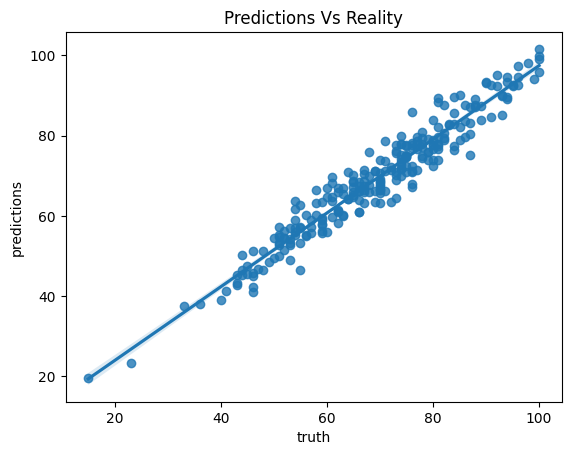

In [17]:
# Create & Display a regression plot
sns.regplot(data=predictions_df, x='truth', y='predictions')
plt.title("Predictions Vs Reality")
plt.show()

## Training Model Using Only Demographic Data

Realistically, testing scores for each unit/chapter likely become available at a similar time as the professor grades them. Therefore, while historical test scores could potentially be used to try and predict future scores, it's worth a shot to attempt to train the model using exclusively demographic data points.

In [18]:
# Score data columns to be removed
scores = ['math score', 'reading score', 'writing score']

### Writing score 

In [19]:
# Retrain model and find R2-score using no test score data to predict writing score
dummy_df = pd.get_dummies(df, drop_first = True)

y = dummy_df["writing score"]
X = dummy_df.drop(columns = scores)

Retrain_Model(X, y)

R2-score: 0.343


### Reading score

In [20]:
# Retrain model and find R2-score using no test score data to predict reading score
dummy_df = pd.get_dummies(df, drop_first = True)

y = dummy_df["reading score"]
X = dummy_df.drop(columns = scores)

Retrain_Model(X, y)

R2-score: 0.216


### Math scores 

In [21]:
# Retrain model and find R2-score using no test score data to predict math score
dummy_df = pd.get_dummies(df, drop_first = True)

y = dummy_df["math score"]
X = dummy_df.drop(columns = scores)

Retrain_Model(X, y)

R2-score: 0.264


# Conclusion From Demographic-Driven Model Approach:
Unfortunately, using exclusively demographic data points yields unconvincing results. The writing score was the easiest for the model to predict, and even then it only managed an R2-score of 0.343.

As it turns out, arguably the biggest predictor for test scores in one subject are test scores in other subjects.

As shown in the heatmap below, the test scores are between 79% and 95% correlated with one another.

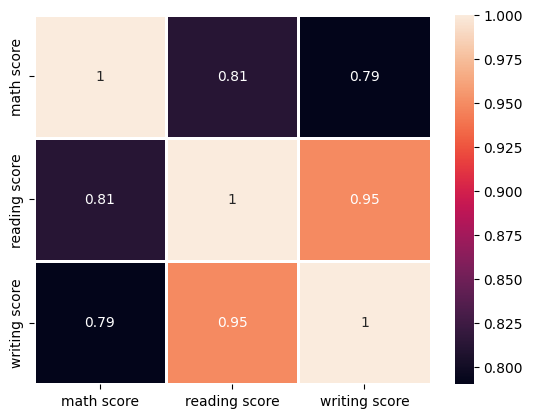

In [22]:
# Create heatmap plot
sns.heatmap(df[scores].corr(),annot=True,lw=1)
plt.show()

### Random Forest

In [23]:
# Retrain model and find R2-score using no test score data to predict writing score
dummy_df = pd.get_dummies(df, drop_first = True)

y_RF = dummy_df["writing score"]
X_RF = dummy_df.drop(columns = scores)

In [24]:
# Create RandomForestRegressor object
regr = RandomForestRegressor(random_state=1)

# Drop score columns from Training data
X_RF_Train = X_train.drop(columns = ["math score", "reading score"])

# Fit the RandomForestRegressor model to the training data
regr.fit(X_RF_Train, y_train)

RandomForestRegressor(random_state=1)

In [25]:
# Drop score columns from Training data
X_RF_Test = X_test.drop(columns = ["math score", "reading score"])

# Evaluate RandomForestRegressor model
regr.score(X_RF_Test, y_test)

0.2867782543059706

[]

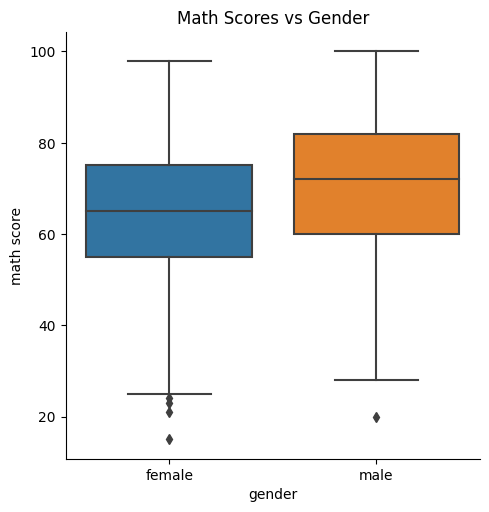

In [26]:
# Create & Display a categorical plot (box plot)
sns.catplot(data=df, x='gender', y='math score', kind='box')
plt.title("Math Scores vs Gender")
plt.plot()

[]

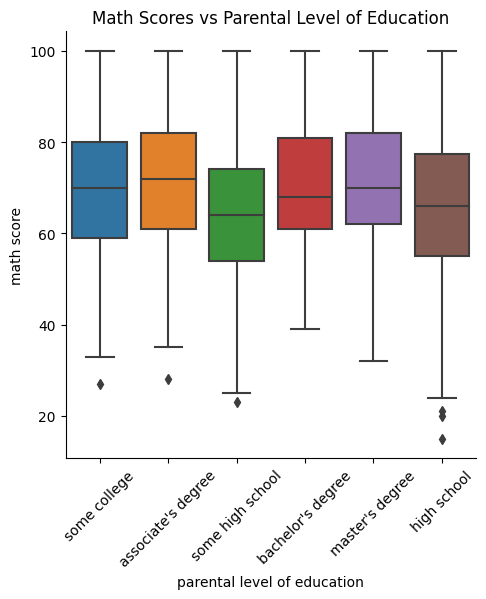

In [27]:
# Create & Display a categorical plot (box plot)
sns.catplot(data=df, x='parental level of education', y='math score', kind='box')
plt.xticks(rotation=45)
plt.title("Math Scores vs Parental Level of Education")
plt.plot()

[]

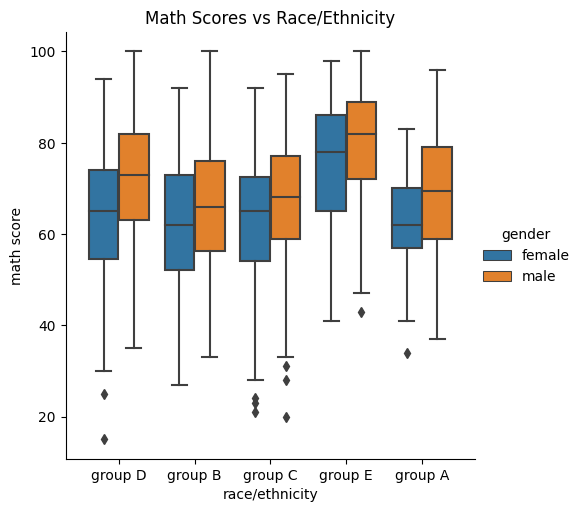

In [28]:
# Create & Display a categorical plot (box plot)
sns.catplot(data=df, x='race/ethnicity', y='math score', kind='box', hue='gender')
plt.title("Math Scores vs Race/Ethnicity")
plt.plot()

In [29]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1, max_iter=200)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

lr_score = r2_score(y_true=y_test, y_pred=logistic_regression_model.predict(X_test_scaled))
lr_score

0.7929652911882183

In [30]:
SVRmodel = SVR(kernel='linear')
SVRmodel.fit(X_train_scaled, y_train)

SVRmodel_score = r2_score(y_true=y_test, y_pred=SVRmodel.predict(X_test_scaled))
SVRmodel_score

0.9346067544679574

In [31]:
dmodel = tree.DecisionTreeRegressor()
dmodel = dmodel.fit(X_train_scaled, y_train)
predictions = dmodel.predict(X_test_scaled)

dmodel_score = dmodel.score(X_test_scaled, y_test)
dmodel_score

0.8583930825304673

In [32]:
kmodel = KNeighborsRegressor(n_neighbors=3)
kmodel.fit(X_train_scaled, y_train)
# Create predictions
y_pred = kmodel.predict(X_test_scaled)
KNRmodel_score = r2_score(y_true=y_test, y_pred=y_pred)
KNRmodel_score

0.8649655431137963

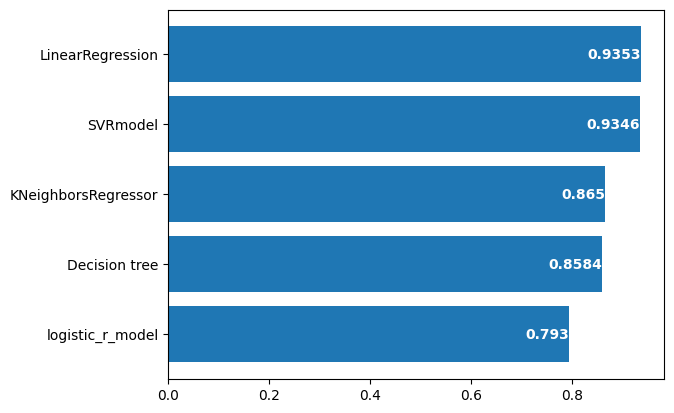

In [33]:
# Setup Data Labels and Round Scores to 3 Decimal Places
labels = ['logistic_r_model', 'Decision tree', 'KNeighborsRegressor', 'SVRmodel', 'LinearRegression']
label_scores = [lr_score, dmodel_score, KNRmodel_score, SVRmodel_score, model.score(X_test_scaled, y_test)]
rounded_scores = [round(score, 4) for score in label_scores]

# Create Bar Chart
plt.barh(labels, label_scores)

# Add Data Labels to Chart
for i, v in enumerate(rounded_scores):
    plt.text(v, i, str(v), color='white', fontweight='bold', ha='right', va='center')

# Display Chart
plt.show()

# Acknowledging the Inevitable:
With our Random Forest approach also yielding less than desirable results we had to acknowledge the inevitable. The demographic data provided is simply insufficient to predict student test scores by itself. We needed to add some  test score data to the model to have a chance of reaching our 0.80 threshold.

[]

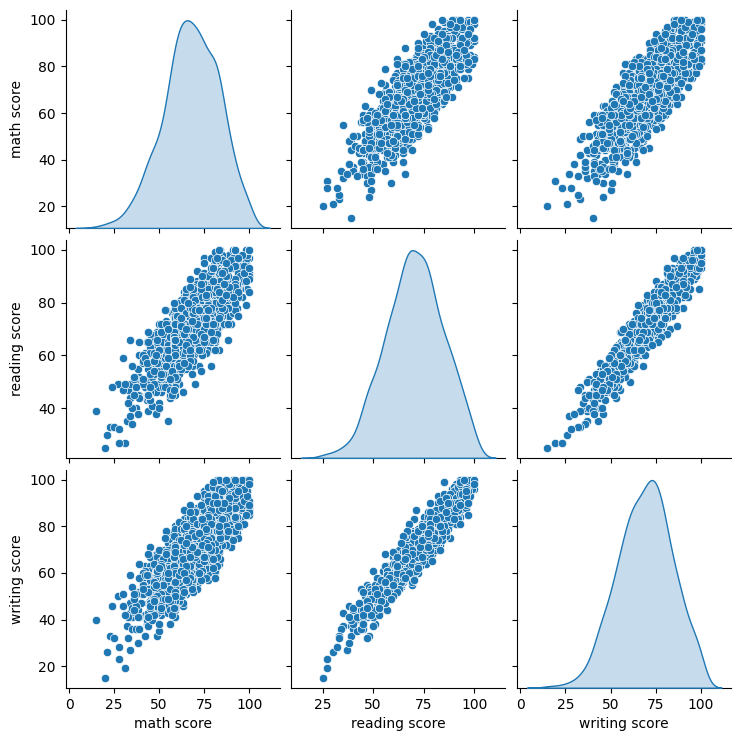

In [34]:
# Create & Display pairwise scatter plot to determine best scores to use for training data (most correlated)
sns.pairplot(df[scores], diag_kind='kde')
plt.plot()

It turns out that the most correlated pair of test scores are reading and writing (as shown above) therefore we decided to use those two data points to retrain the model.

The following R2-score is found using only the reading score to train the model to predict the writing score. As you can see the retrained model scores considerably better when incorporating this data than it does when focusing on demographic factors alone.

In [35]:
# Retrain model and find R2-score using only reading score to predict writing score
X = df[['reading score']]
y = df[['writing score']]

Retrain_Model(X, y)

R2-score: 0.897


When incorporating the demographic data and both the math and reading scores to predict the writing score the model's performance improved further.

This final version of the model managed an R2-score of 0.935 or an improvement of 0.038 compared to the previous version of the model which only used the reading score to make its prediction.

In [36]:
# Display Overall Model Performance (Best Run)
r2 = model.score(X_test_scaled, y_test)
print("R2-score:", r2)

R2-score: 0.9352951918718841


As shown below the root mean squared (RMS) error is lower than the standard deviation of the target variable in the above model.

In [37]:
# Compute the metrics for the linear regression model
# score = model.score(X, y, sample_weight=None)
# r2 = r2_score(y_test, model.predict(X_test_scaled))
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))
# rmse = np.sqrt(mse)
std = np.std(y['writing score'])

# Print releveant metrics.
# print(f"The score is {score}.")
# print(f"The r2 is {r2}.")
# print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The root mean squared error is 3.834412374720831.
The standard deviation is 15.018402045490726.


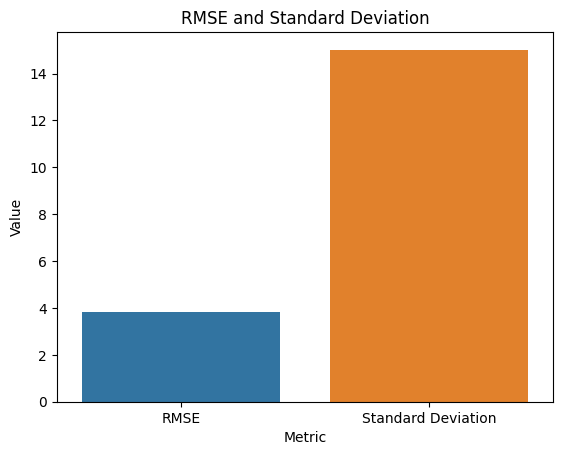

In [38]:
# Create DataFrame for plot
data = {'Metric': ['RMSE', 'Standard Deviation'], 'Value': [rmse, std]}
RMSE_df = pd.DataFrame(data)

# Create and display bar plot
sns.barplot(data=RMSE_df, x='Metric', y='Value')
plt.title('RMSE and Standard Deviation')
plt.show()

First try to Optimize model

In [39]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [48]:
exam_scores_drop_df = df

In [49]:
# Drop math & reading score.
exam_scores_df = exam_scores_drop_df.drop(columns=['math score', 'reading score'])
exam_scores_df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,writing score
0,female,group D,some college,standard,completed,78
1,male,group D,associate's degree,standard,none,87
2,female,group D,some college,free/reduced,none,77
3,male,group B,some college,free/reduced,none,63
4,female,group D,associate's degree,standard,none,86
...,...,...,...,...,...,...
995,male,group C,some college,standard,none,71
996,male,group C,some college,standard,none,66
997,female,group A,high school,standard,completed,86
998,male,group E,high school,standard,none,62


In [50]:
# Determine the number of unique values in each column.
exam_scores_df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
writing score                  74
dtype: int64

In [51]:
# Convert categorical data to numeric with `pd.get_dummies`
exam_scores_df = pd.get_dummies(exam_scores_df)
exam_scores_df

,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,78,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
1,87,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
2,77,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1
3,63,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1
4,86,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,71,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
996,66,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
997,86,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
998,62,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1


In [52]:
# Split our preprocessed data into our features and target arrays
y = exam_scores_df["writing score"].values
X = exam_scores_df.drop(["writing score"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=58)

<ipython-input-52-b43c1c412bfb>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = exam_scores_df.drop(["writing score"],1).values


In [53]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [56]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 144       
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [58]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
24/24 [==============================] - 2s 3ms/step - loss: 5060.6284 - mse: 5060.6284
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 5018.5620 - mse: 5018.5620
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 4976.4126 - mse: 4976.4126
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 4932.2148 - mse: 4932.2148
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 4882.0918 - mse: 4882.0918
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 4824.2363 - mse: 4824.2363
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 4755.4312 - mse: 4755.4312
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 4674.3550 - mse: 4674.3550
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 4577.8540 - mse: 4577.8540
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 4468.7886 - mse: 4468.7886

In [59]:
# Evaluate the model using the test data
#model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
#print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

r2_score(y_test,nn.predict(X_test_scaled))

8/8 [==============================] - 0s 3ms/step


0.04736178921726708

In [60]:
nn.predict(X_test_scaled)

8/8 [==============================] - 0s 4ms/step


array([[ 61.01644 ],
       [ 68.95615 ],
       [ 47.7418  ],
       [ 57.719547],
       [ 90.73653 ],
       [ 69.4942  ],
       [ 70.66984 ],
       [ 77.86618 ],
       [ 87.17517 ],
       [ 53.93814 ],
       [ 72.784   ],
       [ 72.784   ],
       [ 82.92168 ],
       [ 71.04648 ],
       [ 66.02855 ],
       [ 69.4942  ],
       [ 75.04774 ],
       [ 70.58665 ],
       [ 55.85152 ],
       [ 80.977554],
       [ 68.76157 ],
       [ 76.76999 ],
       [ 53.597458],
       [ 75.92853 ],
       [ 68.95615 ],
       [101.21069 ],
       [ 77.86618 ],
       [ 67.67864 ],
       [ 76.76999 ],
       [ 74.619736],
       [ 77.86618 ],
       [ 67.81143 ],
       [ 84.65201 ],
       [ 62.005775],
       [ 71.13954 ],
       [ 85.078094],
       [ 61.461533],
       [ 75.04774 ],
       [ 48.609135],
       [ 82.15457 ],
       [ 65.45155 ],
       [ 56.81404 ],
       [ 68.023605],
       [ 73.85408 ],
       [ 50.38996 ],
       [ 50.38996 ],
       [ 75.03462 ],
       [ 68.0